In [1]:
from utils import load_dataset, train_model, validity_domains, compute_precs_cov_VD
import shap

In [2]:
dataset = "MNIST_mini"
model_name = "image"
X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train, model_name)
print(model.evaluate(X, y))
print(model.evaluate(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 32)          320       
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dropout (Dropout)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 10)                11530     
                                                                 
Total params: 11,850
Trainable params: 11,850
Non-trainable params: 0
_________________________________________________________________
None
32/32 [==============================] - 0s 2ms/step - loss: 1.8327 - accuracy: 0.8020
[1.83269464969635, 0.8019999861717224]
7/7 [==============================] - 0s 2ms/step - 

In [3]:
VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.3,gamma=50, method="DeepSHAP")

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
e = shap.DeepExplainer(model, X_train)
shap_values = e.shap_values(X_test[1:5])
shap.image_plot(shap_values, -X_test[1:5])

In [ ]:
import numpy as np
def compute_precs_cov_VD_img(X, X_train, model, models_VD, replace_empty = True):

    X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_flat=X.reshape(X.shape[0],X.shape[1]*X.shape[2])

    precs = []
    coverages = []
    coverages_train = []
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred = np.argmax(model.predict(X), axis=1)
    for i in range(len(X_train)):
        m=models_VD[i]

        A_train = np.where(m.predict(X_train_flat)==1)
        A = np.where(m.predict(X_flat)==1)
        if np.asarray(A_train).size != 0:
            # pred_i = model.predict(np.asarray(X_train[i]).reshape(1,-1))
            pred_i = y_pred_train[i]
            pred_A = y_pred[A]
            prec = np.sum(pred_i == pred_A)/len(A[0])
            cov_train = len(A_train[0])/len(X_train)
            cov = len(A[0])/len(X)        
            precs.append(prec)
            coverages.append(cov)
            coverages_train.append(cov_train)
        else:
            if replace_empty:
                precs.append(0) 
                coverages.append(0)
                coverages_train.append(0)
    return precs, coverages, coverages_train


In [ ]:
precs,covs,covs_train = compute_precs_cov_VD_img(X, X_train, model, models_VD)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
def explanation_VD_img(idx, X_test, X_train, VD, model, models_VD, explainer, feature_names):
    vd = VD[idx]
    X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    pca = PCA(n_components=2)
    X_train_PCA = pca.fit_transform(X_train_flat)

    X_test_flat=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
    pca = PCA(n_components=2)
    X_test_PCA = pca.fit_transform(X_test_flat)

    plt.figure()
    # disp = DecisionBoundaryDisplay.from_estimator(models_VD[idx], X_train,eps=0.1, grid_resolution=500, alpha=0.4, response_method="predict", plot_method='contour')
    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    plt.scatter(X_train_PCA[:,0],X_train_PCA[:,1], c = y_pred_train, edgecolor='k',cmap='viridis')
    plt.scatter(X_train_PCA[:,0][np.where(vd)],X_train_PCA[:,1][np.where(vd)], edgecolor='k',cmap='winter', marker='X')
    plt.scatter(X_test_PCA[:,0],X_test_PCA[:,1], c='white',edgecolor='k')
    plt.scatter(X_train_PCA[idx,0],X_train_PCA[idx,1], c='r', marker='X')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

    m = models_VD[idx]
    A_train = np.where(m.predict(X_train_flat)==1)
    e = shap.DeepExplainer(model, X_train)
    shap_values = e.shap_values(X_train[A_train])
    shap.image_plot(shap_values, X_train[A_train])
    print(np.argmax(model.predict(X_train[A_train]), axis=1))


    # shap_values = explainer(X_train)

    # m = models_VD[idx]
    # A_train = np.where(m.predict(X_train)==1)
    # print("Explanation")
    # print(shap_values[idx])
    # values = np.argsort(np.abs(shap_values[idx].values))
    # a = np.asarray([[shap_values[idx].values[values[0]], 0],[shap_values[idx].values[values[1]], 1]])
    # plt.scatter(a[:,0],a[:,1],s=100, c='k', marker='X')
    # shap.plots.beeswarm(shap_values[A_train])
    # shap.plots.waterfall(shap_values[idx])

    # data_col = []
    # feature_col = []
    # exp_col = []
    # for i in A_train[0]:
    #     for f in range(len(feature_names)):
    #         data_col.append(X_train[i][f])
    #         feature_col.append(feature_names[f])
    #         exp_col.append(shap_values.values[i][f])
    # df = pd.DataFrame(np.asarray([data_col, feature_col, exp_col]).T, columns=["feature values", "feature names", "exp_col"])
    # df["feature values"] = df["feature values"].astype('float')
    # df["exp_col"] = df["exp_col"].astype('float')

    # norm = plt.Normalize(df["exp_col"].min(), df["exp_col"].max())
    # sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
    # ax = sns.swarmplot(data=df, x="feature names", y="feature values", hue="exp_col", palette="PiYG")
    # data_col = []
    # feature_col = []
    # exp_col = []
    # for f in range(len(feature_names)):
    #     data_col.append(X_train[idx][f])
    #     feature_col.append(feature_names[f])
    #     exp_col.append(shap_values.values[idx][f])
    # df_2 = pd.DataFrame(np.asarray([data_col, feature_col, exp_col]).T, columns=["feature values", "feature names", "exp_col"])
    # df_2["feature values"] = df["feature values"].astype('float')
    # df_2["exp_col"] = df["exp_col"].astype('float')
    # sns.swarmplot(data=df_2, x="feature names", y="feature values", hue="exp_col", color="k", marker='X',size = 10)
    # sm.set_array([])

    # # Remove the legend and add a colorbar
    # ax.get_legend().remove()
    # ax.figure.colorbar(sm)
    # ax.text(1.02, -0.05, "SHAP values", ha="left", va="top", transform=ax.transAxes)
    # plt.savefig('toy_ex/inverted_beeswarm.pdf')
    # plt.show()
    # # ax = sns.swarmplot(data=pd.DataFrame(X_train[A_train],columns=feature_names))
    # # ax.set(xlabel="Features", ylabel="Value", title="Data distribution in validity domain")


In [ ]:
np.argsort(np.asarray(precs)+np.asarray(covs))[::-1]

In [ ]:
precs[513]

In [ ]:
covs[513]

In [ ]:
explanation_VD_img(644, X_test, X_train, VD, model, models_VD, explainer, feature_names)

# Grid search

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, pairwise_distances

def compute_VD_and_scores_img(X, X_train, model,threshold_diff, gamma, shap_values, shap_values_train, dists_exp, replace_empty=True):

    if threshold_diff=="auto":
        threshold_diff = 0.1 * X_train.shape[1]/2
        print("threshold_diff =",threshold_diff)
    VD = np.asarray(dists_exp<threshold_diff).astype(int)

    X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    X_flat=X.reshape(X.shape[0],X.shape[1]*X.shape[2])

    models_VD=[OneClassSVM(nu=0.01,gamma=gamma).fit(X_train_flat[np.where(vd)]) for vd in VD]

    precs = []
    coverages = []
    coverages_train = []
    dist_exp = []
    dist_exp_train = []
    dist_obs = []
    dist_obs_train = []


    empty_VD = 0

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    y_pred = np.argmax(model.predict(X), axis=1)

    for i in range(len(X_train_flat)):
        m=models_VD[i]

        A_train = np.where(m.predict(X_train_flat)==1)
        A = np.where(m.predict(X_flat)==1)

        if np.asarray(A).size != 0:
            d = pairwise_distances(X_flat[A], metric="cosine")
            dist_obs.append(np.max(d))

            d_exp = pairwise_distances(shap_values[A], metric="cosine")
            dist_exp.append(np.max(d_exp))

        if np.asarray(A_train).size != 0:
            d_train = pairwise_distances(X_train_flat[A_train], metric="cosine")
            dist_obs_train.append(np.max(d_train))

            d_exp_train = pairwise_distances(shap_values_train[A_train], metric="cosine")
            dist_exp_train.append(np.max(d_exp_train))

            pred_i = y_pred_train[i]
            pred_A = y_pred[A]
            prec = np.sum(pred_i == pred_A)/len(A[0])
            cov_train = len(A_train[0])/len(X_train)
            cov = len(A[0])/len(X)        
            precs.append(prec)
            coverages.append(cov)
            coverages_train.append(cov_train)
        else:
            empty_VD+=1
            if replace_empty:
                precs.append(0) 
                coverages.append(0)
                coverages_train.append(0)

    return precs, coverages, dist_exp, empty_VD

In [ ]:
# explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
# shap_values = explainer(X)
# shap_values_train = explainer(X_train)
# dists_exp = pairwise_distances(shap_values_train.values)

e = shap.DeepExplainer(model, X_train)
shap_values = np.asarray(e.shap_values(X))
shap_values_train = np.asarray(e.shap_values(X_train))

y_pred_train = np.argmax(model.predict(X_train), axis=1)
E_train = [shap_values_train[int(y_pred_train[i])][i] for i in range(shap_values_train.shape[1])]
E_train = np.asarray(E_train)
E_train = E_train.reshape(E_train.shape[0],E_train.shape[1]*E_train.shape[2])

y_pred = np.argmax(model.predict(X), axis=1)
E = [shap_values[int(y_pred[i])][i] for i in range(shap_values.shape[1])]
E = np.asarray(E)
E = E.reshape(E.shape[0],E.shape[1]*E.shape[2])
dists_exp = pairwise_distances(E_train, metric="cosine")

In [ ]:
precs, coverages, dist_exp, empty_VD = compute_VD_and_scores_img(X, X_train, model, 0.9, 50, E, E_train, dists_exp, replace_empty=True)

In [ ]:
from tqdm import tqdm
def grid_search_VD_v2_img(gammas, tds, X, X_train, model):

    e = shap.DeepExplainer(model, X_train)
    shap_values = np.asarray(e.shap_values(X))
    shap_values_train = np.asarray(e.shap_values(X_train))

    y_pred_train = np.argmax(model.predict(X_train), axis=1)
    E_train = [shap_values_train[int(y_pred_train[i])][i] for i in range(shap_values_train.shape[1])]
    E_train = np.asarray(E_train)
    E_train = E_train.reshape(E_train.shape[0],E_train.shape[1]*E_train.shape[2])

    y_pred = np.argmax(model.predict(X), axis=1)
    E = [shap_values[int(y_pred[i])][i] for i in range(shap_values.shape[1])]
    E = np.asarray(E)
    E = E.reshape(E.shape[0],E.shape[1]*E.shape[2])
    dists_exp = pairwise_distances(E_train, metric="cosine")

    results_dict = {'hp':[],
                     'precisions':[],
                     'coverages':[],
                     'dist exp':[],
                     'empty VDs':[]}
    with tqdm(total=len(gammas) * len(tds)) as pbar:
        for gamma in gammas:     
            for td in tds:
                precs, covs, dist_exp, empty_VD = compute_VD_and_scores_img(X, X_train, model, td, gamma, E, E_train, dists_exp, replace_empty=True)
                results_dict['precisions'].append(precs)
                results_dict['coverages'].append(covs)
                results_dict['dist exp'].append(dist_exp)
                results_dict['empty VDs'].append(empty_VD)
                results_dict['hp'].append((gamma,td))
                pbar.update(1)
    return results_dict

In [ ]:
gammas = np.linspace(40, 50, 10)
tds = np.linspace(0.5, 2, 15)

In [ ]:
results = grid_search_VD_v2_img(gammas, tds, X, X_train, model)

In [ ]:
results.keys()

In [ ]:
def best_hp_VD(mean_precs, mean_cov, empty_VDs):
    return np.argmax(np.asarray(mean_precs)+np.asarray(mean_cov)-np.asarray(empty_VDs))


In [ ]:
len(results['dist exp'][2])

In [ ]:
mean_precs = np.mean(results['precisions'],axis=1)
std_precs = np.std(results['precisions'],axis=1)
mean_cov = np.mean(results['coverages'],axis=1)
std_cov = np.std(results['coverages'],axis=1)
# mean_dist_exp = np.mean(results['dist exp'],axis=1)
# std_dist_exp = np.std(results['dist exp'],axis=1)
empty_VDs = results['empty VDs']

In [ ]:
best = best_hp_VD(mean_precs, mean_cov, empty_VDs)

In [ ]:
print("Best score :")
print(best)
print("hp values", results['hp'][best])
print("Avg Precision", mean_precs[best], "+/-", std_precs[best])
print("Avg Coverage", mean_cov[best], "+/-", std_cov[best])

# MNIST HD

In [1]:
from utils import train_model, validity_domains
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap

In [2]:
feature_names = []

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X=np.concatenate((X_train,X_test))
y=np.concatenate((y_train,y_test))
X = X/255
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
np.shape(X)

(70000, 28, 28, 1)

In [5]:
model = train_model(X_train,y_train, model_name="image")
print(model.evaluate(X, y))
print(model.evaluate(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dropout (Dropout)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 10)                216330    
                                                                 
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________
None
1244/2188 [================>.............] - ETA: 7s - loss: 0.0819 - accuracy: 0.9769

KeyboardInterrupt: 

In [ ]:
X_train_subset = X_train[np.random.choice(np.arange(len(X_train)), 100, replace=False)]

In [ ]:
e = shap.DeepExplainer(model, X_train_subset)

In [ ]:
shap_values = e.shap_values(X_test[1:5])
shap.image_plot(shap_values, -X_test[1:5])

In [ ]:
from utils import get_explanations
def validity_domain(idx,X_train,threshold_diff=0.5,gamma=20):
    VD = np.asarray(dists_exp<threshold_diff).astype(int)
    vd = VD[idx]
    clf = OneClassSVM(nu=0.01,gamma=gamma).fit(X_train[np.where(vd)])
    model_VD=clf
    return VD, model_VD

In [ ]:
explanations, explainer = get_explanations("DeepSHAP", model, X_train, feature_names)

In [ ]:
import pickle
from sklearn.metrics import pairwise_distances

In [ ]:
# pickle.dump(explanations, open("explanations_MNIST.p", "wb"))
explanations = pickle.load(open("explanations_MNIST.p", "rb"))

In [ ]:
y_pred = np.argmax(model.predict(X_train), axis=1)
E = [explanations[i][int(y_pred[i])] for i in range(len(explanations))]
dists_exp = pairwise_distances(E, metric="cosine")

In [ ]:
# VD, model_VD = validity_domain(0,X_train,threshold_diff=0.5,gamma=20)
VD = np.asarray(dists_exp<0.001).astype(int)

In [ ]:
for i in range(len(VD)):
    vd = VD[i]
    print(i,X_train[np.where(vd)].shape)
    if X_train[np.where(vd)].shape[0]>100:
        break

In [ ]:
from sklearn.svm import OneClassSVM
X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
vd = VD[7]
clf = OneClassSVM(nu=0.01,gamma=20).fit(X_train_flat[np.where(vd)])

In [ ]:
def explanation_VD_img(idx, X_test, X_train, VD, model, model_VD, feature_names):
    vd = VD[idx]
    X_train_flat=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
    # pca = PCA(n_components=2)
    # X_train_PCA = pca.fit_transform(X_train_flat)

    # X_test_flat=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
    # pca = PCA(n_components=2)
    # X_test_PCA = pca.fit_transform(X_test_flat)

    # plt.figure()
    # # disp = DecisionBoundaryDisplay.from_estimator(models_VD[idx], X_train,eps=0.1, grid_resolution=500, alpha=0.4, response_method="predict", plot_method='contour')
    # y_pred_train = np.argmax(model.predict(X_train), axis=1)
    # plt.scatter(X_train_PCA[:,0],X_train_PCA[:,1], c = y_pred_train, edgecolor='k',cmap='viridis')
    # plt.scatter(X_train_PCA[:,0][np.where(vd)],X_train_PCA[:,1][np.where(vd)], edgecolor='k',cmap='winter', marker='X')
    # plt.scatter(X_test_PCA[:,0],X_test_PCA[:,1], c='white',edgecolor='k')
    # plt.scatter(X_train_PCA[idx,0],X_train_PCA[idx,1], c='r', marker='X')
    # plt.xlabel(feature_names[0])
    # plt.ylabel(feature_names[1])
    # plt.xlabel("$x_0$")
    # plt.ylabel("$x_1$")
    # plt.show()

    m = model_VD
    A_train = np.where(m.predict(X_train_flat)==1)
    X_train_subset = X_train[np.random.choice(np.arange(len(X_train)), 100, replace=False)]
    # print(idx)
    # print(A_train)
    e = shap.DeepExplainer(model, X_train_subset)

    # shap_values = e.shap_values(X_train[A_train][0:5])
    # shap.image_plot(shap_values, X_train[A_train][0:5])

    # shap_values = np.asarray(e.shap_values(X_train[A_train]))
    # # print(shap_values.shape)
    # pred=np.argmax(model.predict(X_train[A_train]), axis=1)
    # # print(pred)
    # shap_values_flatten = shap_values[pred[0]].reshape(shap_values.shape[1],shap_values.shape[2]*shap_values.shape[3])
    # d_exp = pairwise_distances(shap_values_flatten, metric="cosine")
    # nearest = np.argsort(d_exp[0])[0:5]
    # print(nearest)

    # shap_values = e.shap_values(X_train[A_train][nearest])
    # shap.image_plot(shap_values, X_train[A_train][nearest])

    d_obs = pairwise_distances(X_train_flat[A_train], metric="cosine")
    # print(d_obs)
    furthest = np.argsort(d_obs[0])[::-1][0:2]

    furthest = np.append(furthest,0)

    preds=np.argmax(model.predict(X_train), axis=1)
    same_class = np.where(preds == preds[idx])
    # print(same_class.shape)
    # same_class = np.where(np.argmax(y_train, axis=1) == np.argmax(y_train[idx]))
    # d_obs = pairwise_distances(X_train_flat[same_class], metric="cosine")
    # most_furtherest = np.argsort(d_obs[idx])[::-1][0:8]
    # most_furtherest = np.argsort(dists_exp[idx])[same_class[0]][::-1][0]
    most_furtherest = same_class[0:10]
    print(most_furtherest)
    # furthest = np.append(furthest,most_furtherest)
    # print(A_train[furthest].tolist())
    # print(A_train[0])
    # print(furthest)
    l = A_train[0][furthest].tolist()
    # print(l)
    # l.append(1)
    print(l)
    X_subset = X_train[l]
    # print(X_train[A_train][furthest].shape)
    # print(X_train[most_furtherest].shape)
    # X_subset = np.append(X_train[A_train][furthest],X_train[most_furtherest], axis=0)
    # X_subset = X_train[A_train][furthest]
    # print(X_subset.shape)
    shap_values = e.shap_values(X_subset)
    shap.image_plot(shap_values[4], X_subset)
    # print(most_furtherest)
    # print(X_train[most_furtherest].shape)
    # shap_values = e.shap_values(X_train[most_furtherest])
    shap.image_plot(shap_values[4], X_train[most_furtherest])
    shap_values = e.shap_values(X_train[most_furtherest])
    # shap.image_plot(shap_values[4], X_train[most_furtherest])

In [ ]:
np.argmax(y_train[7])

In [ ]:
np.argmax(y_train, axis=1)

In [ ]:
np.where(np.argmax(y_train, axis=1) == np.argmax(y_train[7]))

In [ ]:
explanation_VD_img(7, X_test, X_train, VD, model, clf, feature_names)

In [ ]:
explanation_VD_img(7, X_test, X_train, VD, model, clf, feature_names)

In [ ]:
np.where(VD[7])

In [ ]:
preds=np.argmax(model.predict(X_train), axis=1)

In [ ]:
np.where(preds == preds[7])

# MNIST HD scaled dist and class sep

In [158]:
from utils import train_model
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import numpy as np
import shap

In [159]:
feature_names = []
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X=np.concatenate((X_train,X_test))
y=np.concatenate((y_train,y_test))
X = X/255
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y = keras.utils.to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
model = train_model(X_train,y_train, model_name="image")
print(model.evaluate(X, y))
print(model.evaluate(X_test, y_test))

2188/2188 [==============================] - 6s 3ms/step - loss: 0.0818 - accuracy: 0.9772
[0.08175007998943329, 0.9771857261657715]
438/438 [==============================] - 1s 3ms/step - loss: 0.1018 - accuracy: 0.9708
[0.10177158564329147, 0.9707857370376587]


In [161]:
X_train_subset = X_train[np.random.choice(np.arange(len(X_train)), 100, replace=False)]

In [162]:
y_pred = model.predict(X_train_subset)
y_pred = np.argmax(y_pred, axis = 1)

4/4 [==============================] - 0s 2ms/step


In [163]:
e = shap.DeepExplainer(model, X_train_subset)

In [164]:
shap_values = e.shap_values(X_train_subset)

In [294]:
E = [shap_values[int(y_pred[i])][i] for i in range(len(X_train_subset))]

In [295]:
E = np.asarray(E).reshape(100,28*28)

In [296]:
classes = np.unique(np.argmax(y, axis = 1))

In [297]:
scaler = MinMaxScaler()
dists_exp = {c : scaler.fit_transform(pairwise_distances(E[np.where(y_pred==c)], metric="cosine")) for c in classes}

In [298]:
threshold_diff = 0.2
VD = {c : np.asarray(dists_exp[c]<threshold_diff).astype(int) for c in classes}

In [299]:
pred_idx = {c : np.where(y_pred==c)[0] for c in classes}
print(pred_idx)

{0: array([ 7, 30, 33, 34, 55, 62, 66, 80, 88, 94, 95], dtype=int64), 1: array([ 6,  8, 12, 19, 21, 32, 52, 60, 83, 99], dtype=int64), 2: array([73, 92, 97], dtype=int64), 3: array([11, 20, 24, 29, 38, 44, 51, 65, 78], dtype=int64), 4: array([ 2, 31, 36, 46, 49, 50, 58, 61, 63, 67, 81], dtype=int64), 5: array([ 1,  4,  5, 13, 18, 25, 39, 43, 56, 64, 70, 71, 77, 84, 90, 96],
      dtype=int64), 6: array([ 9, 16, 17, 22, 45, 47, 69, 75, 79], dtype=int64), 7: array([10, 41, 48, 53, 59, 74, 91], dtype=int64), 8: array([14, 26, 28, 57, 68, 72, 76, 85, 86, 89, 93, 98], dtype=int64), 9: array([ 0,  3, 15, 23, 27, 35, 37, 40, 42, 54, 82, 87], dtype=int64)}


In [300]:
for c in classes:
    print("____",c,"____")
    for i,v in enumerate(VD[c]):
        tot=np.sum(v)
        if tot>1:
            print(i, pred_idx[c][i], tot)
    print("___________")

____ 0 ____
___________
____ 1 ____
2 12 2
5 32 3
6 52 2
8 83 2
___________
____ 2 ____
___________
____ 3 ____
___________
____ 4 ____
___________
____ 5 ____
___________
____ 6 ____
___________
____ 7 ____
___________
____ 8 ____
___________
____ 9 ____
___________


In [305]:
i=12
c = y_pred[i]
X_train_c = X_train_subset[pred_idx[c]]
VD_c = VD[c]
idx_vd = np.where(pred_idx[c]==i)[0][0]
print(VD_c[idx_vd])
print(pred_idx[c])

[0 0 1 0 0 1 0 0 0 0]
[ 6  8 12 19 21 32 52 60 83 99]


In [306]:
oui = pred_idx[c][np.where(VD_c[idx_vd])]
print(oui)

[12 32]


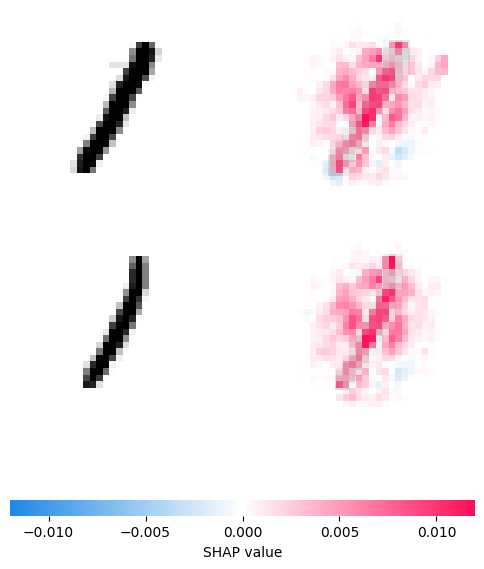

In [307]:
shap.image_plot(shap_values[c][oui], -X_train_subset[oui])
# shap.image_plot(shap_values[:,oui], -X_train_subset[oui])

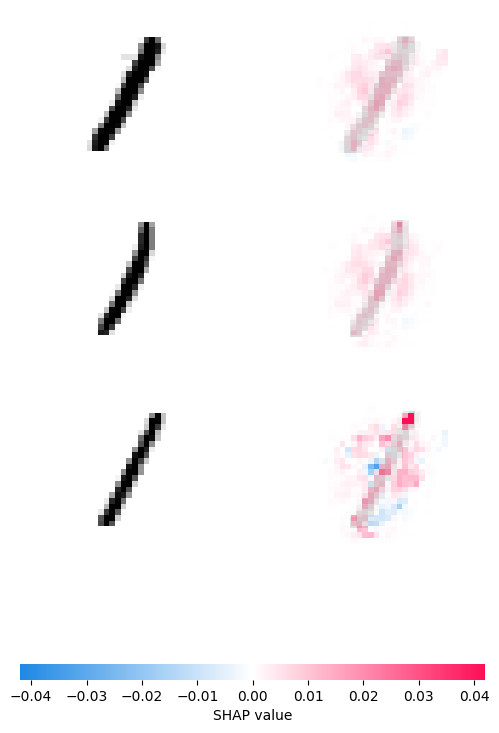

In [309]:
non = [12, 32, 6]
shap.image_plot(shap_values[c][non], -X_train_subset[non])